Import Libraries

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
import os
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf 
!pip install tensorflow_io
import tensorflow_io as tfio
from tensorflow import keras
from keras import backend as k
import time
from keras.callbacks import EarlyStopping

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1. Process Audio into Spectogram

Read all audio files and sort

In [60]:
TRAIN = os.path.join('/content','drive','MyDrive','audio-dataset', 'Train')
TEST = os.path.join('/content','drive','MyDrive','audio-dataset', 'Test')
#TRAIN = os.path.join('audio-data', 'Train')
#TEST = os.path.join('audio-data', 'Test')
train = tf.data.Dataset.list_files(TRAIN+'/*.wav')
train = sorted(list(train.as_numpy_iterator()))
train = tf.data.Dataset.from_tensor_slices(train)
test = tf.data.Dataset.list_files(TEST+'/*.wav')
test = sorted(list(test.as_numpy_iterator()))
test = tf.data.Dataset.from_tensor_slices(test)

Add Labels

In [61]:
num_classes = 10
iterations = 0
i = 0
train_label = []
while iterations!=len(train):
    iterations +=1
    train_label.append(i)
    i += 1
    if i == num_classes :
        i = 0
trainings = tf.data.Dataset.zip((train, tf.data.Dataset.from_tensor_slices(train_label)))
#---------------------------------------------------------------#
iterations = 0
i = 0
test_label=[]
while iterations!=len(test):
    iterations +=1
    test_label.append(i)
    i += 1
    if i == num_classes :
        i = 0
testings = tf.data.Dataset.zip((test, tf.data.Dataset.from_tensor_slices(test_label)))

Build Preprocessing Function to get spectogram

In [62]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [63]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    #wav = wav[:48000]
    #zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    #wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

Convert all to Spectogram

In [64]:
# train data
x_train = trainings.map(preprocess)
x_train = x_train.cache()
x_train = x_train.shuffle(buffer_size=1000)
x_train = x_train.batch(16) # 16 at a time
x_train = x_train.prefetch(8)
# test data
x_test = testings.map(preprocess)
x_test = x_test.cache()
x_test = x_test.shuffle(buffer_size=1000)
x_test = x_test.batch(16) # 16 at a time
x_test = x_test.prefetch(8)

In [65]:
# test one batch
samples, labels = x_train.as_numpy_iterator().next()
print(samples.shape)
print('\n',labels[0:10],'\n...')

(16, 391, 257, 1)

 [9 3 1 3 3 0 0 6 0 6] 
...


# 2. CNN no Attention

Design the CNN architecture

In [66]:
from keras.models import Sequential
from keras import layers

In [67]:
model=Sequential()
input_shape = (391, 257, 1)
model.add( layers.Input(shape=input_shape) )
model.add( layers.Conv2D(16,kernel_size=(3,3),activation='relu',name="conv2D_1") )
model.add( layers.MaxPooling2D(pool_size=(2,2)) )
model.add( layers.Dropout(0.5) )
model.add( layers.Flatten() )
model.add( layers.Dense(num_classes,activation='softmax',name="output") )
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2D_1 (Conv2D)           (None, 389, 255, 16)      160       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 194, 127, 16)     0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 194, 127, 16)      0         
                                                                 
 flatten_2 (Flatten)         (None, 394208)            0         
                                                                 
 output (Dense)              (None, 10)                3942090   
                                                                 
Total params: 3,942,250
Trainable params: 3,942,250
Non-trainable params: 0
____________________________________________

Training

In [68]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']
             )

In [69]:
early_stopping = EarlyStopping(monitor='accuracy', patience=5)
tic=time.time()
hist = model.fit(x_train,
                epochs=15,
                shuffle=True,
                callbacks=[early_stopping],
                validation_data=x_test
                )
toc=time.time()
training_time=toc-tic

Epoch 1/15
75/75 [==============================] - 16s 102ms/step - loss: 1.2748 - accuracy: 0.7108 - val_loss: 0.7785 - val_accuracy: 0.7933
Epoch 2/15
75/75 [==============================] - 2s 29ms/step - loss: 0.2650 - accuracy: 0.9433 - val_loss: 2.4135 - val_accuracy: 0.6467
Epoch 3/15
75/75 [==============================] - 2s 27ms/step - loss: 0.1548 - accuracy: 0.9675 - val_loss: 1.9680 - val_accuracy: 0.7767
Epoch 4/15
75/75 [==============================] - 3s 34ms/step - loss: 0.1148 - accuracy: 0.9733 - val_loss: 1.7449 - val_accuracy: 0.7667
Epoch 5/15
75/75 [==============================] - 2s 28ms/step - loss: 0.0584 - accuracy: 0.9858 - val_loss: 2.1507 - val_accuracy: 0.7967
Epoch 6/15
75/75 [==============================] - 2s 23ms/step - loss: 0.1713 - accuracy: 0.9692 - val_loss: 1.8018 - val_accuracy: 0.8033
Epoch 7/15
75/75 [==============================] - 2s 23ms/step - loss: 0.1478 - accuracy: 0.9775 - val_loss: 2.0914 - val_accuracy: 0.7800
Epoch 8/15


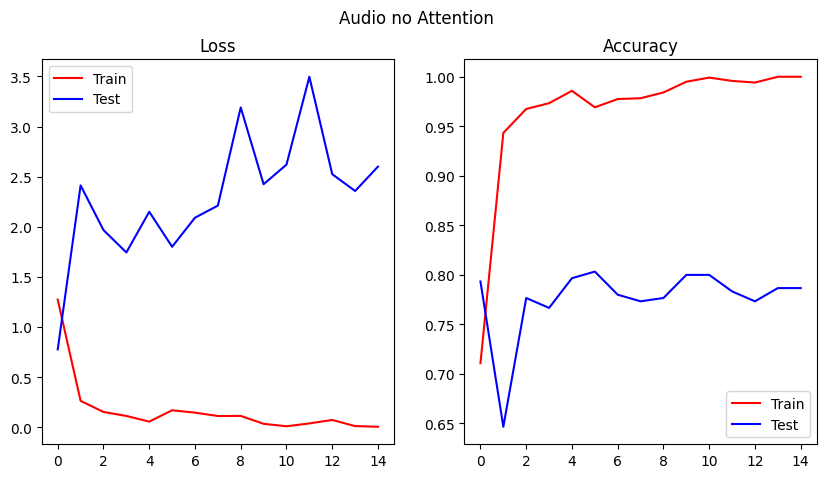

In [70]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.legend(["Train", "Test"], loc=0, frameon=True)
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], 'r')
plt.plot(hist.history['val_accuracy'], 'b')
plt.legend(["Train", "Test"], loc=0, frameon=True)
plt.suptitle("Audio no Attention")
plt.show()

In [71]:
tic=time.time()
test_loss, test_acc = model.evaluate(x_test)
toc=time.time()
test_time=toc-tic
print("Training Time = {} s".format(np.round(training_time, 1)))
print("Testing Time = {} ms".format(np.round(test_time*1000, 1)))
print('Test Loss = {:.2f} %:'.format(np.round(test_loss, 3)*100))
print('Test Accuracy = {:.2f} %:'.format(np.round(test_acc, 3)*100))

19/19 [==============================] - 0s 6ms/step - loss: 2.6007 - accuracy: 0.7867
Training Time = 50.8 s
Testing Time = 154.2 ms
Test Loss = 260.10 %:
Test Accuracy = 78.70 %:


# 3. CNN with Attention

Design the CNN architecture

In [72]:
from keras import Model

In [78]:
inputs = keras.layers.Input(shape=input_shape)
conv = keras.layers.Conv2D(16,kernel_size=(3,3),activation='relu', name="Conv2D_1")(inputs)
#Attention
attention = keras.layers.Conv2D(1, (3,3), padding='same', activation='sigmoid', name="Conv2D_2")(conv)
attention_mul = keras.layers.Multiply(name="Spatial_Attn")([conv, attention])
##########
pool = keras.layers.MaxPool2D(pool_size=(2,2))(attention_mul)
drop = keras.layers.Dropout(0.5, name="Drop_1")(pool)
flatten = keras.layers.Flatten(name="Flat_1")(drop)
dense2 = keras.layers.Dense(num_classes,activation='softmax',name="Output")(flatten)
modelAtt = keras.Model(inputs=inputs, outputs=dense2)

modelAtt.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 391, 257, 1  0           []                               
                                )]                                                                
                                                                                                  
 Conv2D_1 (Conv2D)              (None, 389, 255, 16  160         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 Conv2D_2 (Conv2D)              (None, 389, 255, 1)  145         ['Conv2D_1[0][0]']               
                                                                                            

Training

In [79]:
modelAtt.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']
             )

In [80]:
early_stopping = EarlyStopping(monitor='accuracy', patience=5)
tic=time.time()
hist = modelAtt.fit(x_train,
                batch_size=32,
                epochs=15,
                shuffle=True,
                callbacks=[early_stopping],
                validation_data=x_test
                )
toc=time.time()
training_time=toc-tic

Epoch 1/15
75/75 [==============================] - 5s 43ms/step - loss: 1.4001 - accuracy: 0.7042 - val_loss: 0.6852 - val_accuracy: 0.8233
Epoch 2/15
75/75 [==============================] - 3s 39ms/step - loss: 0.2900 - accuracy: 0.9467 - val_loss: 0.9931 - val_accuracy: 0.7967
Epoch 3/15
75/75 [==============================] - 3s 39ms/step - loss: 0.1528 - accuracy: 0.9700 - val_loss: 1.5794 - val_accuracy: 0.7600
Epoch 4/15
75/75 [==============================] - 3s 40ms/step - loss: 0.0935 - accuracy: 0.9833 - val_loss: 1.8092 - val_accuracy: 0.7800
Epoch 5/15
75/75 [==============================] - 3s 42ms/step - loss: 0.1085 - accuracy: 0.9850 - val_loss: 1.4628 - val_accuracy: 0.8167
Epoch 6/15
75/75 [==============================] - 3s 39ms/step - loss: 0.1191 - accuracy: 0.9758 - val_loss: 1.7071 - val_accuracy: 0.8000
Epoch 7/15
75/75 [==============================] - 3s 39ms/step - loss: 0.0891 - accuracy: 0.9817 - val_loss: 1.5399 - val_accuracy: 0.8433
Epoch 8/15
75

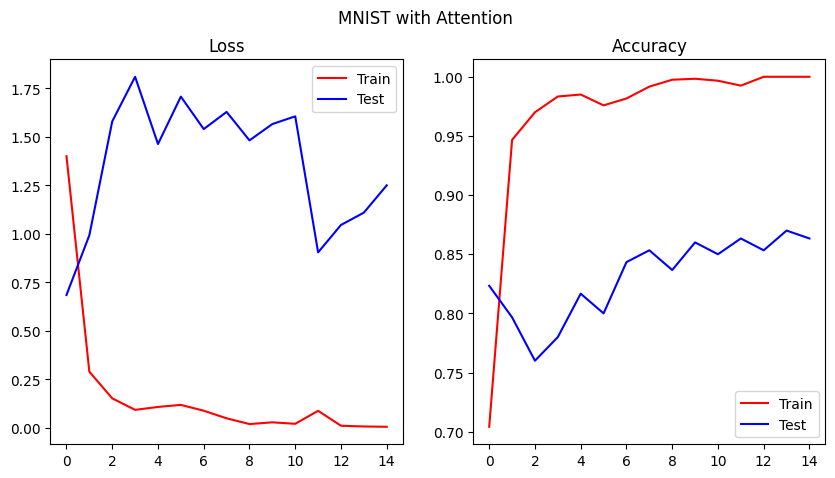

In [81]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.legend(["Train", "Test"], loc=0, frameon=True)
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], 'r')
plt.plot(hist.history['val_accuracy'], 'b')
plt.legend(["Train", "Test"], loc=0, frameon=True)
plt.suptitle("MNIST with Attention")
plt.show()

In [82]:
tic=time.time()
test_loss, test_acc = modelAtt.evaluate(x_test)
toc=time.time()
test_time=toc-tic
print("Training Time = {} s".format(np.round(training_time, 1)))
print("Testing Time = {} ms".format(np.round(test_time*1000, 1)))
print('Test Loss = {:.2f} %:'.format(np.round(test_loss, 3)*100))
print('Test Accuracy = {:.2f} %:'.format(np.round(test_acc, 3)*100))

19/19 [==============================] - 0s 12ms/step - loss: 1.2501 - accuracy: 0.8633
Training Time = 50.8 s
Testing Time = 240.9 ms
Test Loss = 125.00 %:
Test Accuracy = 86.30 %:
